In [78]:
import torch
import torchaudio
import torch.nn.functional as F
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

## 0. Experimenting with TorchAudio

In [80]:
exampleAudio = "canterburytales_09_chaucer_64kb_0000.flac"

waveform, sampleRate = torchaudio.load(exampleAudio)
print(waveform.shape, sampleRate)

torch.Size([1, 936960]) 16000


In [79]:
metadata = torchaudio.info(exampleAudio, format = "flac")
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=936960, num_channels=1, bits_per_sample=16, encoding=FLAC)


In [31]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

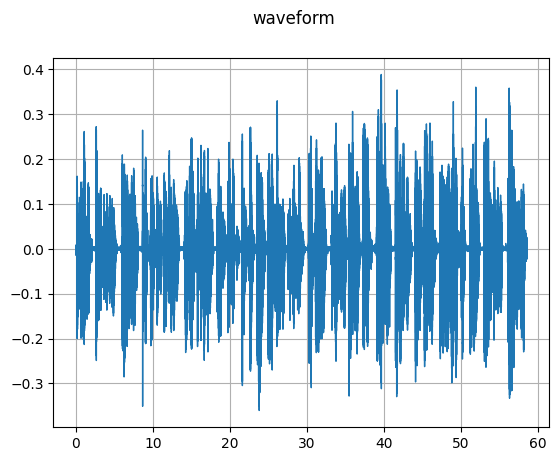

In [30]:
plot_waveform(waveform, sampleRate)

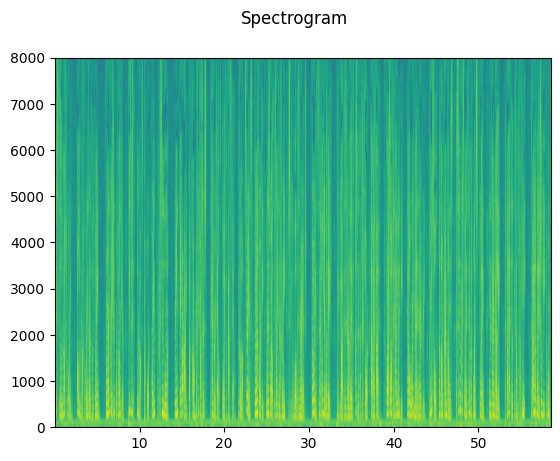

In [32]:
plot_specgram(waveform, sampleRate)

In [132]:
from IPython.display import Audio

#Audio(waveform.numpy()[0], rate=sampleRate)

In [72]:
waveform2 = torchaudio.functional.lowpass_biquad(waveform, sampleRate, 50, 0.707)
#waveform2 = torchaudio.functional.pitch_shift(waveform, sampleRate, -10)
Audio(waveform2.numpy()[0], rate=sampleRate)

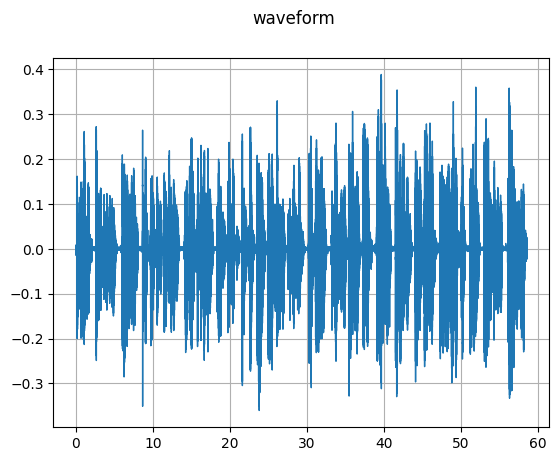

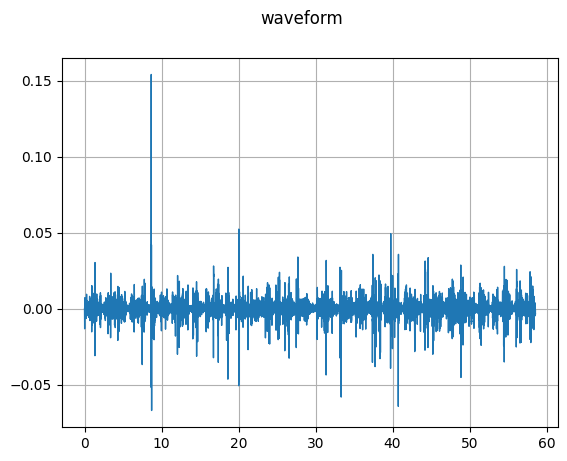

In [73]:
plot_waveform(waveform, sampleRate)
plot_waveform(waveform2, sampleRate)

In [64]:
# save new Audio
torchaudio.save("out.flac",waveform2,sampleRate)

## 1. Creating the Dataset

In [47]:
from torchaudio.transforms import Resample

In [146]:
class LibriDataset(Dataset):

    def __init__(self, audioDir, newSampleFreq, maxLenght):
        self.audioList = self.getAudioList(audioDir)
        self.resampler = Resample(new_freq=newSampleFreq)
        self.maxLenght = maxLenght

    def getAudioList(self,audioDir):
        flac_files = []
        for root, dirs, files in os.walk(audioDir):
            for file in files:
                if file.endswith(".flac"):
                    file_path = os.path.join(root, file)
                    flac_files.append(file_path)
        return flac_files


    def __len__(self):
        return len(self.audioList)

    def __getitem__(self, idx):
        waveform, sampleRate = torchaudio.load(self.audioList[idx])
        waveformResampled = self.resampler(waveform)
        waveformPadded = F.pad(waveformResampled, pad = (0,self.maxLenght - len(waveformResampled[0])))
        
        return waveformPadded


In [147]:
SAMPLE_FREQ = 16000
AUDIO_MAX_DURATION = 60

trainDataset = LibriDataset("data_cut", newSampleFreq = SAMPLE_FREQ, maxLenght = SAMPLE_FREQ * AUDIO_MAX_DURATION)

len(trainDataset),trainDataset[2][0].shape

(36229, torch.Size([960000]))

In [148]:
BATCH_SIZE = 64

dataLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)

In [149]:
for idx, waveform in enumerate(dataLoader):
    print(idx, waveform)
    break

0 tensor([[[ 6.1035e-05,  6.1035e-05,  6.1035e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 4.2114e-03,  4.0588e-03,  3.9978e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00, -9.1553e-05, -9.1553e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        ...,

        [[-3.6011e-03, -4.2114e-03, -4.1809e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-4.5776e-04,  2.5330e-03, -2.7466e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-5.7983e-04, -3.6621e-04, -1.0071e-03,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]])


In [144]:
Audio(trainDataset[0][0], rate = SAMPLE_FREQ)

1 959999
829440 960000
